# Auto-Regressive Models
## Understand how auto-regressive large language models generate text token by token.

In [50]:
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

## Initialize the model and the tokenizer

In [51]:
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


Here's a brief explanation of each component:

- `GPT2LMHeadModel`: The main model class.
  - `transformer`: The core transformer model.
    - `wte`: Token embeddings.
    - `wpe`: Positional embeddings.
    - `drop`: Dropout layer.
    - `h`: List of transformer blocks (`GPT2Block`).
      - Each `GPT2Block` contains:
        - `ln_1`: Layer normalization.
        - `attn`: Self-attention mechanism (`GPT2SdpaAttention`).
          - `c_attn`: Linear transformation for query, key, and value.
          - `c_proj`: Linear transformation for the output.
          - `attn_dropout`: Dropout for attention.
          - `resid_dropout`: Dropout for residual connection.
        - `ln_2`: Layer normalization.
        - `mlp`: Feed-forward neural network (`GPT2MLP`).
          - `c_fc`: Linear transformation for the hidden layer.
          - `c_proj`: Linear transformation for the output layer.
          - `act`: Activation function (GELU).
          - `dropout`: Dropout layer.
    - `ln_f`: Final layer normalization.
  - `lm_head`: Linear layer for language modeling head.

# tokenizing the prompt

In [52]:
prompt = "The quick brown fox jumps over the"
inputs = tokenizer(prompt, return_tensors="pt")
for k, v in inputs.items():
    print(k , ":" , v)

input_ids : tensor([[  464,  2068,  7586, 21831, 18045,   625,   262]])
attention_mask : tensor([[1, 1, 1, 1, 1, 1, 1]])


`input_ids` : the mapping from particular chunks of the text 
            into these tokens from the tokniizer

`attention_mask`: a tensor that goes along with input_ids for
                the purpose of determining what tokens within
                the particular input_ids are should be attended to
                which other tokens. (there is 1 for each input token id.)

 # predict and look at the shape of the logits tensor

In [53]:
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
print(logits.shape)

torch.Size([1, 7, 50257])


`1` - batch size

`7` - the sequence length that we pass in

`50257` - the vocabulary size which how many possible tokens that we might 
        generate in the output

# to get the logits for the last token in the input sequence

In [54]:
last_logits = outputs.logits[0, -1, :]

`[0, -1, :] `

`"0"` : the first batch

`"-1"`: correspond to the last token in the input sequence
      because we are trying to predict the next token of the input sequence
      so we just focus on the last token 

`":"`: all the possible tokens that we might generate in the output

# to get the most likely token that we might generate in the output

In [55]:
next_token_id = last_logits.argmax()
print(next_token_id)

tensor(13990)


# to get the top 10 most likely tokens that we might generate in the output

In [56]:
top_k = torch.topk(last_logits, k=10)
tokens = [tokenizer.decode(token_id) for token_id in top_k.indices]
print(tokens)

[' fence', ' edge', ' wall', ' table', ' top', ' ground', ' bar', ' railing', ' tree', ' fox']



### how do we use these probabilities to generate text? 

This is where decoding strategies, such as greedy search and beam search, come into play.
ref :[Decoding Strategies in Large Language Models](https://mlabonne.github.io/blog/posts/2023-06-07-Decoding_strategies.html)

#  how to construct the next input ?

In [57]:
next_inpusts = {
    "input_ids": torch.cat([inputs["input_ids"], next_token_id.reshape((1, 1))], dim=1),
    "attention_mask": torch.cat(
        [
            inputs["attention_mask"],
            torch.ones((1, 1)).type_as(inputs["attention_mask"]),
        ],
        dim=1,
    ),
}


# Furthemore, let's try to calculate the time taken to generate the next token

In [58]:
# a helper function that generate token id 
def generate_token(inputs):
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id


generated_tokens = []
next_inputs = inputs
durations_s = []
for _ in range(10):
    t0 = time.time()
    # 注意这里每次都要重新传入全部next_inputs
    next_token_id = generate_token(next_inputs)
    durations_s += [time.time() - t0]

    # 将新生成的 token 拼接到输入
    next_inputs = {
        "input_ids": torch.cat(
            [next_inputs["input_ids"], next_token_id.reshape((1, 1))], dim=1
        ),
        "attention_mask": torch.cat(
            [
                next_inputs["attention_mask"],
                torch.tensor([[1]]),
            ],
            dim=1,
        ),
    }

    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

print(f"sum(durations_s) = {sum(durations_s)} s")
print(f"generated_tokens = {generated_tokens}")



sum(durations_s) = 0.7307431697845459 s
generated_tokens = [' fence', ' and', ' runs', ' into', ' the', ' bushes', '.', '\n', '\n', '"']


# try to look at the time consumed for each token generation


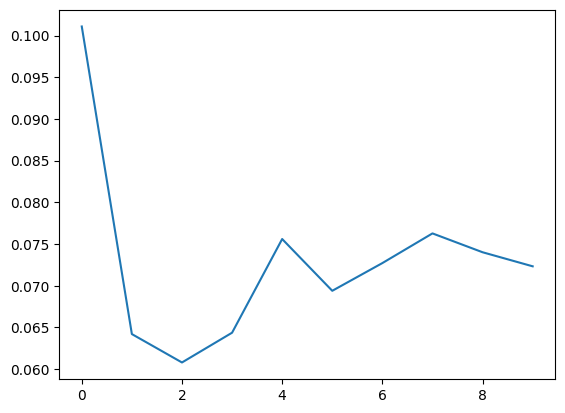

In [59]:
import matplotlib.pyplot as plt

plt.plot(durations_s)
plt.show()


Generally, it takes more and more time to generate a new token because the input length becoome longer and longer 

# Use kv cache to improve the performernce

这个机制看上去只适合用在decoder only的模型

- 1这种模型的 ”未来的输出“ 不会影响 ”以前的输出”。 
- 在产生新的输出token时，旧的K信息是要用到的（想一下矩阵乘法，就是，新Q的最后一行，要和以前的旧V矩阵相乘），又基于第一点，旧的K矩阵可以缓存起来。
- 在产生新的输出token时，V的旧值也是不变的，直接缓存起来。

ref：
- [kv-cache、decoder only vs. BERT, 单向注意力 vs. 双向注意力](https://www.bilibili.com/video/BV1sw4m1v7sa/?spm_id_from=333.999.top_right_bar_window_history.content.click&vd_source=27d3b33a76014ebb5a906ad40fa382de)
- [[LLMs 实践] 20 llama2 源码分析 cache KV（keys、values cache）加速推理
](https://www.bilibili.com/video/BV1FB4y1Z79y/?spm_id_from=333.999.0.0&vd_source=27d3b33a76014ebb5a906ad40fa382de)

Modify the generate helper function to return the next token and the key/value tensors

In [60]:
def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id, outputs.past_key_values # !!返回 past_key_values


Generate 10 tokens using the updated helper function

In [61]:
durations_cached_s = []
generated_tokens = []
next_inputs = inputs
for _ in range(10):
    t0 = time.time()
    next_token_id, past_key_values = generate_token_with_past(next_inputs)
    durations_cached_s += [time.time() - t0]
    next_inputs  =  {
        "input_ids": next_token_id.reshape((1, 1)),
        "attention_mask": torch.cat([
            next_inpusts["attention_mask"],
            torch.tensor([[1]])
        ], dim=1),
        "past_key_values": past_key_values
    }
    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)
print(f"sum(durations_cached_s) = {sum(durations_cached_s)} s")
print(f"generated_tokens = {generated_tokens}")



sum(durations_cached_s) = 0.565244197845459 s
generated_tokens = [' fence', ' and', ' runs', ' into', ' the', ' bushes', '.', '\n', '\n', '"']


# watch the effect

[0.10108447074890137, 0.06419849395751953, 0.06079292297363281, 0.06436276435852051, 0.07559609413146973, 0.06938886642456055, 0.07271313667297363, 0.07627129554748535, 0.07401132583618164, 0.07232379913330078]


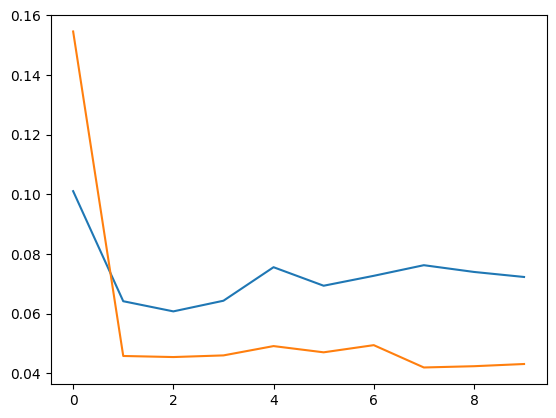

In [62]:
plt.clf()
plt.plot(durations_s)
print(durations_s)
plt.plot(durations_cached_s)
plt.show()